In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from IPython import display

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device   = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")

Tesla P100-PCIE-16GB


In [3]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=Tr

In [4]:
from google.colab import files
uploaded = files.upload()

Saving play RRO 2.0-short.mp4 to play RRO 2.0-short.mp4


In [5]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

play RRO 2.0-short.mp4


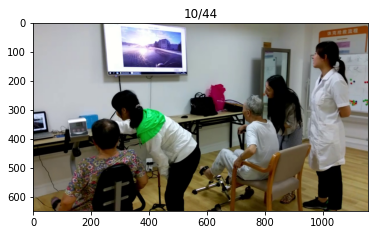

In [6]:
# 看一下影片 frames
First_tracking_frame = 1
End_tracking_frame =  10 
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
print('No. of frames = ', total_frames)
frame_count = 1
while(cap.isOpened()):  
    if(frame_count > End_tracking_frame):
        break
    success, frame = cap.read()  # Capture frame-by-frame
    if success == True:
        # 先把 frame 轉到 First_tracking_frame, show 出此 frame 上 subject index
        if(frame_count < First_tracking_frame):
            frame_count += 1
        else:
            display.clear_output(wait=True)
            plt.title(str(frame_count)+'/'+str(total_frames))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
            plt.imshow(frame)
            plt.show()
            plt.pause(0.1)
            frame_count = frame_count + 1
cap.release()

# 加上 pose estimation

In [7]:
#          'nose'白色, 'left_eye'黑色, 'right_eye', 'left_ear', 'right_ear',  
#          'left_shoulder',  'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
#          'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
#           Left -  Green
#           Right - Red
colorMap = [(255, 255, 255), (0, 0, 0), (0, 0, 0), (255, 255, 255),(255, 255, 255), 
            (0, 255, 0), (255, 0, 0), (0, 255, 0), (255, 0, 0), (0, 255, 0), (255, 0, 0),
            (0, 255, 0), (255, 0, 0), (0, 255, 0), (255, 0, 0), (0, 255, 0), (255, 0, 0)]

In [8]:
# 畫線 0 (nose)-3(LEar), 0-4, ...
PtPairLst = [[0,3], [0, 4], [5, 6], [5, 7], [7, 9], [6, 8], [8, 10], [11, 13], [13, 15], [11, 12], [12, 14], [14, 16]]

In [9]:
# keyPts = the 17 key points of this person (x1, y1, visiablity1), ...
# frame = the image to draw the skeleton
def draw_skeleton(frame_count, frame, keyPts):
    frame_Lst = [frame_count]
    for i in range(17):
        x = keyPts[i][0]
        y = keyPts[i][1]
        cv2.circle(frame, (x, y), radius=10, color=colorMap[i], thickness=10) 
        frame_Lst = frame_Lst + [x, y]

    # 多畫 2 個點: 5 (LShoulder)-6 (RS) 中間,  11(LHip)-12(RH) 中間
    x5_6, y5_6, visiablity1  = (keyPts[5] + keyPts[6])/2
    x11_12, y11_12, visiablity2  = (keyPts[11] + keyPts[12])/2
    cv2.circle(frame, (x5_6, y5_6), radius=10, color=(0, 0, 255), thickness=10) 
    cv2.circle(frame, (x11_12, y11_12), radius=10, color=(0, 0, 255), thickness=10) 

    # 畫線 LShoulder-RS 5-6, Left Arm: 5-7-9,  RArm 6-8-10
    # LHip-RHip 11-12, Left Leg: 11-13-15, RLeg: 12-14-16
    # Body 0- (5-6中間)-(11-12 中間) 
    for pointPair in PtPairLst:
        ptIdx1, ptIdx2 = pointPair
        cv2.line(frame, (keyPts[ptIdx1][0], keyPts[ptIdx1][1]), (keyPts[ptIdx2][0], keyPts[ptIdx2][1]), color=(255, 255, 255), thickness=10) 
    cv2.line(frame, (keyPts[0][0], keyPts[0][1]), (x5_6, y5_6), color=(255, 255, 255), thickness=10)
    cv2.line(frame, (x5_6, y5_6), (x11_12, y11_12), color=(255, 255, 255), thickness=10)
    return frame_Lst

In [10]:
End_tracking_frame = 20

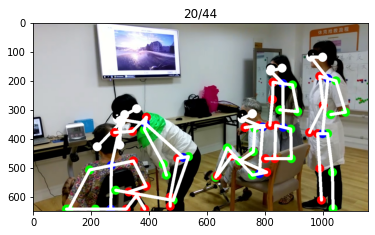

20 frames were read


In [11]:
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
print('No. of frames = ', total_frames)
frame_count = 1
while(cap.isOpened()):  # Read until video is completed
    success, frame = cap.read()  # Capture frame-by-frame
    if success == True:
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
        img = transform(frame).to(device) # Apply the transform to the image
        pred = model([img]) # Pass the image to the model

        # 只取 score > threshold
        pred_score = pred[0]['scores'].cpu().detach().numpy()
        threshold = 0.9
        i = 0
        while i < pred_score.shape[0]:
            if (pred_score[i] < threshold):
                break
            i = i + 1
    
        kp = pred[0]['keypoints'].cpu().detach().numpy()
        kp = kp[:i]
        for person_idx in range(kp.shape[0]):
            draw_skeleton(frame_count, frame, kp[person_idx])
        #plt.figure(figsize=(18,9))  
        plt.imshow(frame)
        plt.pause(0.1)
        frame_count = frame_count + 1
        if(frame_count > End_tracking_frame):
            break
    else:
        break
print(frame_count-1, 'frames were read')
cap.release()